<a href="https://colab.research.google.com/github/tmy-611/Machine_Learning_Models/blob/main/CruiseShip/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Environment


In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,957 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,830 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/un

In [10]:
# Import libraries
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

In [3]:
sc = SparkContext(conf=SparkConf())
spark = SparkSession(sparkContext=sc)

# Linear Regression Consulting Project

Here is what the data looks like so far:

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
It is saved in a csv file called "cruise_ship_info.csv". I am going to create a regression model that will help predict how many crew members will be needed for future ships.


In [4]:
# Import file
from google.colab import files
files.upload()

Saving cruise_ship_info.csv to cruise_ship_info.csv


{'cruise_ship_info.csv': b'Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew\nJourney,Azamara,6,30.276999999999997,6.94,5.94,3.55,42.64,3.55\nQuest,Azamara,6,30.276999999999997,6.94,5.94,3.55,42.64,3.55\nCelebration,Carnival,26,47.262,14.86,7.22,7.43,31.8,6.7\nConquest,Carnival,11,110.0,29.74,9.53,14.88,36.99,19.1\nDestiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.0\nEcstasy,Carnival,22,70.367,20.52,8.55,10.2,34.29,9.2\nElation,Carnival,15,70.367,20.52,8.55,10.2,34.29,9.2\nFantasy,Carnival,23,70.367,20.56,8.55,10.22,34.23,9.2\nFascination,Carnival,19,70.367,20.52,8.55,10.2,34.29,9.2\nFreedom,Carnival,6,110.23899999999999,37.0,9.51,14.87,29.79,11.5\nGlory,Carnival,10,110.0,29.74,9.51,14.87,36.99,11.6\nHoliday,Carnival,28,46.052,14.52,7.27,7.26,31.72,6.6\nImagination,Carnival,18,70.367,20.52,8.55,10.2,34.29,9.2\nInspiration,Carnival,17,70.367,20.52,8.55,10.2,34.29,9.2\nLegend,Carnival,11,86.0,21.24,9.63,10.62,40.49,9.3\nLiberty*,Carnival,8,110.0,29.74,

In [5]:
df = spark.read.csv('cruise_ship_info.csv', header=True, inferSchema=True)
df.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
only showing top 5 rows



In [6]:
# Initialize Spark session
spark = SparkSession.builder.appName("CrewPrediction").getOrCreate()

In [7]:
# Convert Cruise_line to numerical using StringIndexer
indexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_line_index")
data_indexed = indexer.fit(df).transform(df)

# Assemble features vector
assembler = VectorAssembler(
    inputCols=["Age", "Tonnage", "passengers", "length", "cabins", "passenger_density",
               "Cruise_line_index"],
    outputCol="features"
)
data_assembled = assembler.transform(data_indexed)

# Split the data into training and testing sets
train_data, test_data = data_assembled.randomSplit([0.8, 0.2], seed=42)

# Create the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="crew")

# Train the model
model = lr.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="crew", predictionCol="prediction",
                                metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

# Print the results
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


Root Mean Squared Error (RMSE): 0.6866161447133091
R-squared (R2): 0.9535112044507553


In [8]:
predictions.select("prediction", "crew").show()

+------------------+-----+
|        prediction| crew|
+------------------+-----+
| 6.496498937895589|  6.0|
| 5.346373159744126|  5.2|
| 8.836959231520655|  8.5|
| 6.024079863758641| 6.17|
|12.682403972358513| 12.0|
|11.376383220897079|12.38|
| 8.627433925631935|  7.6|
| 8.576830723921612|  9.2|
|11.066295496952275| 11.1|
| 8.617239659146605|  7.6|
| 6.119985003885708|  6.6|
|15.141824284742334| 13.6|
| 4.055137547657446|  4.0|
|  9.26168761445615| 8.69|
|6.7663045753968145|  6.8|
| 4.541903872782736|  3.5|
| 9.579634982321434| 10.3|
|10.194544352310366|  9.0|
| 6.374034862569653|  6.3|
|  8.87621169041217| 8.58|
+------------------+-----+
only showing top 20 rows



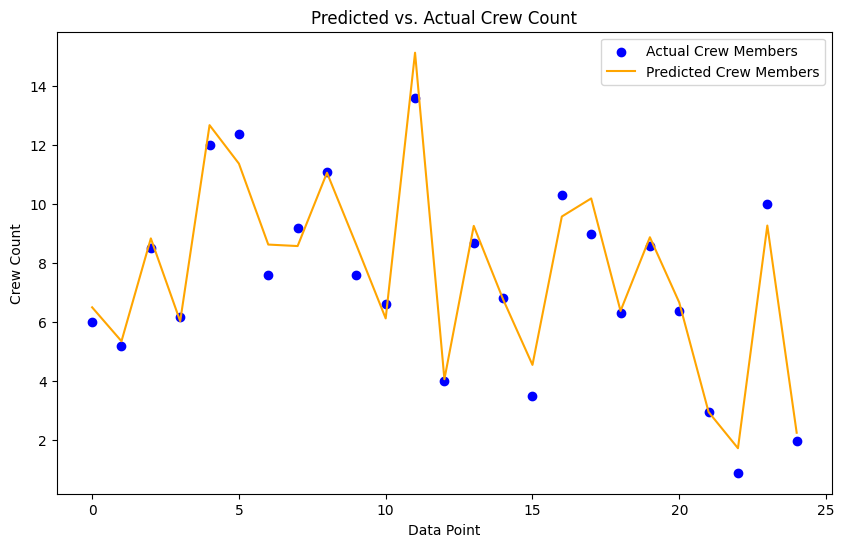

In [11]:
# Extract the predicted and actual values from the predictions DataFrame
predicted_crew = predictions.select("prediction").collect()
actual_crew = predictions.select("crew").collect()

# Prepare the data for plotting
x_values = range(len(predicted_crew))
y_values_predicted = [p[0] for p in predicted_crew]
y_values_actual = [a[0] for a in actual_crew]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values_actual, label="Actual Crew Members",
            color="blue")
plt.plot(x_values, y_values_predicted, label="Predicted Crew Members",
         color="orange")

# Add labels and title
plt.xlabel("Data Point")
plt.ylabel("Crew Count")
plt.title("Predicted vs. Actual Crew Count")

# Add legend and show the plot
plt.legend()
plt.show()


As we can see, the predictions is pretty close to the testing label, so it indicates that this is a good model to predict the crew members that needed for future ships. I think one of the reasons that make the model performs well is that the given dataset is high-quality and well-preprocessed.